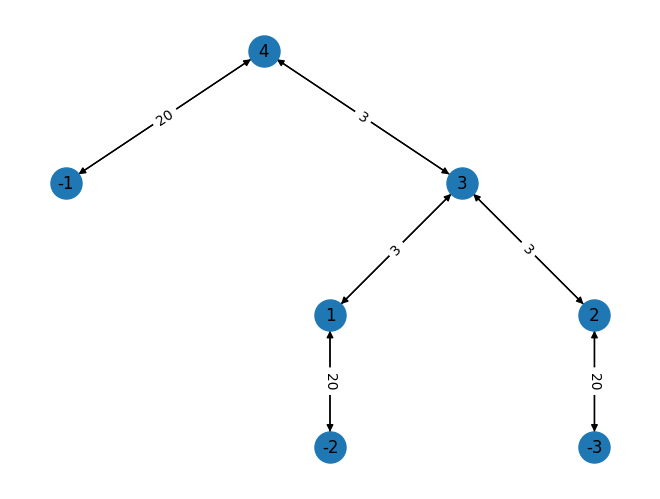

In [1]:
from qutree import *

def parabula(x):
    return np.sum(x**2)

def double_well_2(q):
    x = givens_x(-20.) @ givens_z(10.) @ givens_x(10.) @ q
    #x = q
    v1 = (x[0] - 0.02)**4 - 0.5 * x[0]**2
    v2 = (x[1] - 0.01)**4 - 0.5 * x[1]**2
    v3 = (x[2] - 0.05)**4 - 0.5 * x[2]**2
    return np.exp(-(v1 + v2 + v3))

def double_well(x):
    v1 = 0.5*(x[0]- 0.5)**2 + 0.25 * (x[0] + 0.5)**2
    v2 = 0.5*(x[1]- 0.5)**2 + 0.25 * (x[1] + 0.5)**2
    v3 = 0.5*(x[2]- 0.5)**2 + 0.25 * (x[2] + 0.5)**2
    return np.exp(-(v1 + v2 + v3))

def Err_xyz(x):
    return parabula(x)

def Err_spherical(q):
    x = spherical_to_xyz(q)
    return parabula(x)

N = 20
r = 3
f = 3
#O = Objective(Err_xyz, spherical_linspace(N, include_boundaries= False), spherical_to_xyz)
O = Objective(double_well_2, [linspace(-2., 2., N = N)] * f)
G = balanced_tree(f, r, N)
#G = tt_graph(f, r, N)
G = tn_grid(G, O.linspace)

plot_tree(G)
#plot_tt_diagram(G)

In [2]:
G_opt, df = ttnopt(G, O, nsweep = 5)
fig = grid_animation(df)
fig.show()

In [3]:
from qutree.ttn.tensor_network import *
edges = [(0, 1), (0, 2), (0, 3)]
ranks = [2, 3, 4]
A = quTensor(np.arange(np.prod(ranks)).reshape(ranks), edges)

B = A.flatten((0, 3))


In [4]:
import numpy as np
e1 = [(-3, 2), (3, 2)]
e2 = [(1, 3), (2, 3), (4, 3)]
edge = (3, 2)
At = np.arange(20*4).reshape((20, 4))
Bt = np.arange(4*6*5).reshape((6, 4, 5))
A = quTensor(At, e1)
B = quTensor(Bt, e2)

#C2 = np.tensordot(At, Bt, axes=([1], [1]))
C2 = np.einsum(At,[0, 1], Bt, [2, 1, 3], [0, 2, 3])
C = tensordot(A, B, edge)
print(C.edges, C.shape, C2.shape)
print(np.allclose(C2, C))

D = B.flatten((2, 3))
print(D.shape, D.edges)



[(-3, 3), (1, 3), (3, 4)] (20, 6, 5) (20, 6, 5)
True
(30, 4) [((1, 3), (3, 4)), (2, 3)]


In [5]:
e1 = [(3, 2), (2, 3)]
e2 = [(1, 3), (2, 3), (3, 4)]
edge = (2, 3)
matt = np.arange(4*4).reshape((4, 4))
At = np.arange(4*6*5).reshape((6, 4, 5))

mat = quTensor(matt, e1)
A = quTensor(At, e2)

B = tensordot(mat, A, edge)
print(B.edges, B.shape)

[(2, 3), (1, 3), (3, 4)] (4, 6, 5)


In [6]:
edge = (2, 3)

t2 = np.arange(20*4).reshape((20, 4))
t23 = np.arange(4*4).reshape((4, 4))
t3 = np.arange(5*4*6).reshape((5, 4, 6))

A2 = quTensor(t2, [(-3, 2), (2, 3)])
A23 = quTensor(t23, [(2, 3), (3, 2)])
A3 = quTensor(t3, [(3, 4), (2, 3), (1, 3)])

B = tensordot(A23, A2, edge)

print('A2: ', A2.edges, A2.shape)
print('A23:', A23.edges, A23.shape)
print('A3: ', A3.edges, A3.shape)
print('A2@A23:', B.edges, B.shape)
C = tensordot(A3, B, edge)
print('C:', C.edges, C.shape)

A2:  [(-3, 2), (2, 3)] (20, 4)
A23: [(2, 3), (2, 3)] (4, 4)
A3:  [(3, 4), (2, 3), (1, 3)] (5, 4, 6)
A2@A23: [(2, 3), (-3, 3)] (4, 20)
C: [(3, 4), (1, 3), (-3, 3)] (5, 6, 20)


difference:  0.0


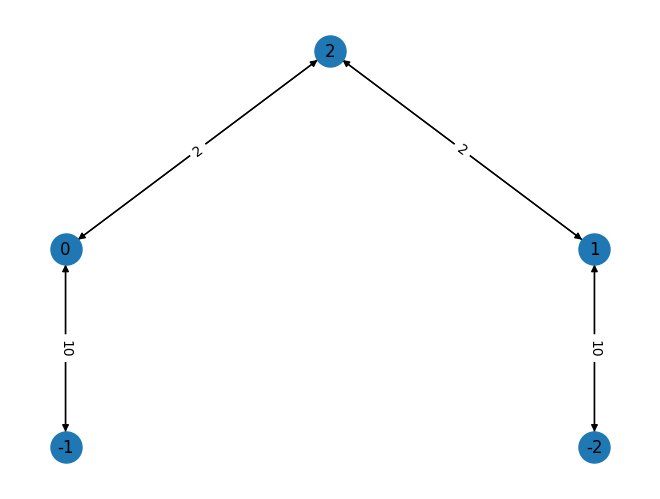

In [7]:
N = 10
r = 2
f = 2
# compress manually
A0 = np.arange(N * r).reshape((N, r))
A2 = np.arange(r*r).reshape((r, r))
B = np.tensordot(A0, A2, axes=([1], [0]))

A1 = np.arange(N * r).reshape((N, r))
C = np.tensordot(B, A1, axes=([1], [1]))

G = balanced_tree(f, r, N)
G = create_tensors(G, np.arange, 'A')
plot_tree(G)
F = contract(G)
x = F.nodes[2]['A']
print('difference: ', np.linalg.norm(C - x))

In [8]:
def f(x):
    if len(x) == 3:
        return x[0]**2 + x[1]**2 + x[2]**2 + x[0]*x[1] + x[1]*x[2] + x[0]*x[2]
    elif len(x) == 2:
        return np.exp(-(x[0]**2 + x[1]**2 + x[0]*x[1]))

def f_sin(x):
    y = x * np.pi
    if len(x) == 3:
        return np.sin(y[0]) * np.sin(y[1]) * np.sin(y[2])
    if len(y) == 2:
        return np.cos(y[0]) * np.sin(y[1])

dof = 3
r = 6
N = 20
func = f
O = Objective(func, [linspace(-1, 1, N)]*dof)
G = balanced_tree(dof, r, N)
#G = remove_edge(G, (0, 2))
G = tn_grid(G, O.linspace)
Gopt, df = ttnopt(G, O, nsweep = 5)
if dof == 3:
    fig = grid_animation(df)
    fig.show()
#plot_tree(Gopt)
F = contract(Gopt)

if dof == 2:
    F2 = F.nodes[2]['A']

    x1 = Grid(linspace(-1, 1, N), 0)
    x2 = Grid(linspace(-1, 1, N), 1)
    xyz = x1 @ x2
    Fref = xyz.evaluate(func)
    Fref = Fref.reshape((N, N))
    Fref = Fref.transpose([1, 0])
    print(F2.edges)
    print('Error: ', np.linalg.norm(Fref - F2)/np.linalg.norm(Fref))
    print('Error: ', np.linalg.norm(Fref - F2)/N**dof)
#    plt.contour(xyz.grid[:, 0].reshape(N, N), xyz.grid[:, 1].reshape(N, N), (F2).reshape((N, N)), levels=100)  # Using 100 levels for a smoother gradient
    plt.contour(xyz.grid[:, 0].reshape(N, N), xyz.grid[:, 1].reshape(N, N), (np.abs(Fref-F2)).reshape((N, N)), levels=100)  # Using 100 levels for a smoother gradient
#    plt.contour(xyz.grid[:, 0].reshape(N, N), xyz.grid[:, 1].reshape(N, N), (np.abs(Fref-F2)).reshape((N, N)), levels=100)  # Using 100 levels for a smoother gradient
    plt.colorbar()
    plt.title("Contour Plot of f(X, Y)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
elif dof == 3:
    F2 = F.nodes[4]['A']
    x1 = Grid(linspace(-1, 1, N), 0)
    x2 = Grid(linspace(-1, 1, N), 1)
    x3 = Grid(linspace(-1, 1, N), 2)
    xyz = x1 @ x2 @ x3
    Fref = xyz.evaluate(func)
    Fref = Fref.reshape((N, N, N))
    print('Error: ', np.linalg.norm(Fref - F2)/np.linalg.norm(Fref))
    print('Error: ', np.linalg.norm(Fref - F2)/N**dof)


Error:  8.442052422388982e-16
Error:  1.1901553737668796e-17


In [9]:
# cool multi-D plot
#import pandas as pd
#import numpy as np
#
#import matplotlib.pyplot as plt
#
#from sklearn.datasets import load_iris, load_boston, load_wine
#from sklearn.preprocessing import MinMaxScaler
#
#import plotly.express as px
#import plotly.graph_objects as go
#
#boston_df = load_boston()
#
#%matplotlib inline
#cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
#       'PTRATIO', 'B', 'LSTAT',]
#
#fig = go.Figure(data=
#    go.Parcoords(
#        line = dict(color = boston_df['HousePrice'],
#                   colorscale = px.colors.sequential.Blues,
#                   cmin=25, cmax=50),
#        dimensions = [dict(label=col, values=boston_df[col]) for col in cols]
#    )
#)
#
#fig.update_layout(
#    title="Boston House Price Coordinates Plot"
#)
#
#fig.show()

In [10]:

A = np.arange(20).reshape((5, 4))
eps = 1e-12

A_inv = regularized_inverse(A, eps)
print(np.linalg.norm(A @ A_inv - np.eye(5)))
print(np.linalg.norm(A @ A_inv @ A - A))

1.7320508075688772
8.928844003223402e-15


In [11]:
from qutree.matrix_factorizations.maxvol import maxvol, maxvol_rect
N = 20
M = 30
r = 3
eps = 1e-12
A = np.arange(N*M).reshape((M, N)) #+ ran

Ic = sorted(np.random.choice(N, r, replace=False))
cross = np.zeros((r, r))
Ainv = np.zeros((r, r))
Ar = np.zeros((r, N))
Ac = A[:, Ic]
for i in range(0, 5):
    Ac = A[:, Ic]
    Ir, _ = maxvol(Ac.copy())

    Ar = A[Ir, :]
    Ic, _ = maxvol(Ar.T.copy())
    Across = Ar[:, Ic]
    Ainv = regularized_inverse(Across, eps)

Ac = A[:, Ic]
#Ar = A[Ir, :]
#Across = Ar[:, Ic]
#Ainv = regularized_inverse(Across, eps)
A2 = Ac @ Ainv @ Ar
print (np.linalg.norm(A - A2))



3.3135883190104846e-12


In [12]:
N = 20
M = 30
r = 2
eps = 1e-12
A = np.arange(N*M).reshape((M, N)) #+ ran
n = 4
i = np.random.choice(np.min(M), n, replace=False)
j = np.random.choice(np.min(N), n, replace=False)
Ir = [*i]
Ic = [*j]

Ar = A[Ir, :]
Ac = A[:, Ic]
Across = Ac[Ir, :]
Ainv = regularized_inverse(Across, eps)
print(i, j, np.linalg.norm(Ac @ Ainv @ Ar - A))

[19  6 14 13] [ 1 19 14  0] 5.910371149123226e-12


{12: 0, 14: 1, 10: 1, 11: 1, 13: 2, 2: 2, 3: 2, 0: 2, 1: 2, 8: 3, 9: 3, -3: 3, -4: 3, -1: 3, -2: 3, 6: 4, 7: 4, 4: 4, 5: 4, -7: 5, -8: 5, -5: 5, -6: 5}
[(12, 14), (12, 10), (12, 11), (10, 2), (10, 3), (11, 0), (11, 1), (14, 13), (0, -1), (1, -2), (2, -3), (3, -4), (13, 8), (13, 9), (8, 6), (8, 7), (9, 4), (9, 5), (4, -5), (5, -6), (6, -7), (7, -8)]


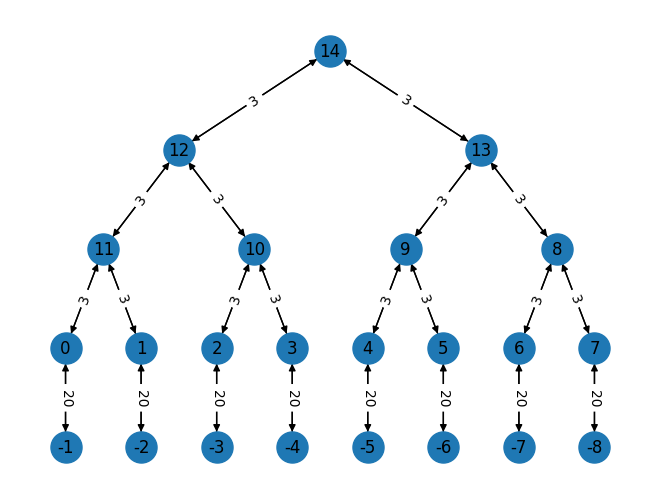

In [13]:
G = balanced_tree(8, 3, 20)
plot_tree(G)
# Define the root node
#root_node = 14
# Compute betweenness centrality for each node
betweenness_centrality = nx.betweenness_centrality(G)

# Choose the node with the highest betweenness centrality as the root node
root_node = max(betweenness_centrality, key=betweenness_centrality.get)

def edges_by_distance_to_root(G, root):
    # Calculate distances from the root node to all other nodes
    distance = nx.shortest_path_length(G, source=root)

    print(distance)

    up_edges = [edge for edge in G.edges() if distance[edge[0]] < distance[edge[1]]]
    down_edges = [edge for edge in G.edges() if distance[edge[0]] > distance[edge[1]]]

    # Sort edges based on distances to the root node
    sorted_edges = sorted(up_edges, key=lambda edge: distance[edge[1]])

    return sorted_edges

print(edges_by_distance_to_root(G, root_node))

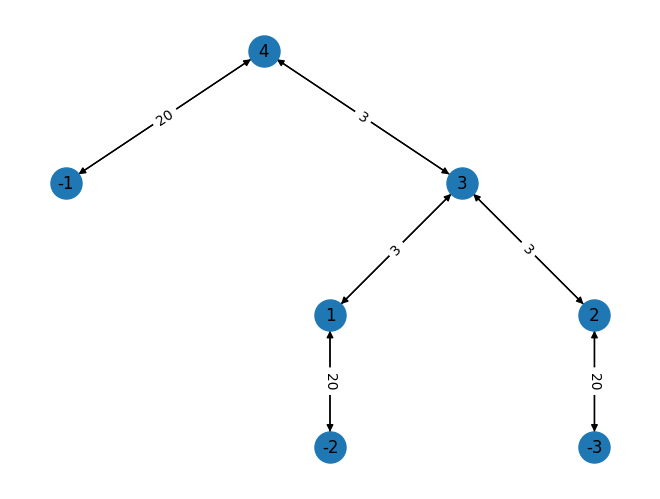

In [14]:
from qutree import *

def parabula(x):
    return np.sum(x**2)

N = 20
r = 3
f = 3
primitive_grid = [linspace(-2., 2., N = N)] * f
O = Objective(parabula, primitive_grid)
G = balanced_tree(f, r, N)

plot_tree(G)
G = tn_grid(G, O.linspace)

#plot_tt_diagram(G)